In [1]:
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings

import matplotlib
from matplotlib import rc
import matplotlib.pyplot as plt 
matplotlib.rcdefaults()

from pathlib import Path
matplotlib_rc = { 
    # 'text': {'usetex': True}, 
    'font': {'family': 'serif'} } # Apply changes for k, v in matplotlib_rc.items(): rc(k, **v)
for k, v in matplotlib_rc.items():
          rc(k, **v)

In [2]:
warnings.filterwarnings('ignore')

In [30]:
def remove_outliers(df, column, lower_percentile=0.05, upper_percentile=0.95):
    """
    Remove outliers from a DataFrame based on percentile method for a specific column for each dataset.
    
    Parameters:
    - df: DataFrame from which to remove outliers.
    - column: Column name to check for outliers.
    - lower_percentile: Lower percentile threshold for outlier removal.
    - upper_percentile: Upper percentile threshold for outlier removal.
    
    Returns:
    - DataFrame with outliers removed.
    """
    def remove_outliers_group(group):
        lower_bound = group[column].quantile(lower_percentile)
        upper_bound = group[column].quantile(upper_percentile)
        new_group = group[(group[column] >= lower_bound) & (group[column] <= upper_bound)]
        print(f"Removed {group.shape[0] - new_group.shape[0]} obs from {group['Dataset'].iloc[0]}")
        return new_group

    return df.groupby('Dataset').apply(remove_outliers_group).reset_index(drop=True)


def plot_log_mean_vs_log_variance(real_adata, generated_adatas_dict, dataset, folder, xlim=(0,100), ylim=(0,100), quantile=(0.0,0.999)):
    """
    Plots the log mean vs log variance for real and generated AnnData objects using seaborn.

    Parameters:
    - real_adata: AnnData object for the real dataset.
    - generated_adatas_dict: Dictionary with model names as keys and AnnData objects as values.
    """
    save_path = Path(folder)
    # Calculate and plot for the real dataset
    # X_real = (np.exp(real_adata.X.A - 1)X_real = (np.exp(real_adata.X.A - 1)))
    X_real = real_adata.X.A
    real_means = np.mean(X_real, axis=0)
    real_vars = np.var(X_real, axis=0)
    # real_means = np.log(np.mean(X_real, axis=0))
    # real_vars = np.log(np.var(X_real, axis=0))
    
    # Create a DataFrame for seaborn
    data = {
        'Mean': list(real_means),
        'Variance': list(real_vars),
        'Dataset': ['Real data' for _ in range(len(real_means))]
    }
    
    for model_name, adata in generated_adatas_dict.items():
        # X = np.exp(adata.X.A - 1)
        X = adata.X.A
        means = np.mean(X, axis=0)
        vars = np.var(X, axis=0)
        # means = np.log(np.mean(X, axis=0))
        # vars = np.log(np.var(X, axis=0))


        # Append to the data dictionary
        data['Mean'] += list(means)
        data['Variance'] += list(vars)
        data['Dataset'] += [model_name for _ in range(len(means))]
    
    # Convert the data dictionary to a DataFrame
    import pandas as pd
    df = pd.DataFrame(data)
    df = remove_outliers(df, 'Mean', lower_percentile=quantile[0], upper_percentile=quantile[1])

    # plt.figure(figsize=(5,7))
    # Plot with seaborn
    pl = sns.lmplot(data=df, x='Mean', y='Variance', hue='Dataset', palette='colorblind', order=2, 
                   scatter=True, height=3, legend=True, line_kws= {"linewidth": 2}, scatter_kws={"s": 20, "alpha": 0.05})
    # pl = sns.scatterplot(data=df, x='Mean', y='Variance', hue='Dataset', palette='colorblind', s=8, alpha=0.5, legend=False)

    if ylim:
        plt.ylim(ylim[0], ylim[1])
    if xlim:
        plt.xlim(xlim[0], xlim[1])
        
    plt.xlabel('Gene mean (log-GEXP)')
    plt.ylabel('Gene variance (log-GEXP)')
    plt.title(dataset)
    plt.xticks(rotation=45)  
    plt.legend()
    plt.tight_layout()
    plt.savefig(save_path / (dataset+".png"), format='png', dpi=800)
    plt.show()

In [31]:
folder ="/home/icb/alessandro.palma/environment/cfgen/figs/overdispersion"

## Dentategyrus

In [32]:
adata_celldreamer_dent = sc.read_h5ad("/home/icb/alessandro.palma/environment/cfgen/project_folder/datasets/generated/dentategyrus/generated_cells_0.h5ad")
adata_scDiff_dent = sc.read_h5ad("/home/icb/alessandro.palma/environment/cfgen/project_folder/baseline_experiments/scDiffusion/generated/dentategyrus/generated_cells_0.h5ad")
# adata_ACTIVA_dent = sc.read_h5ad("/home/icb/alessandro.palma/environment/celldreamer/project_folder/baseline_experiments/ACTIVA/generated/dentategyrus/generated_cells_0.h5ad")
adata_scgan_dent = sc.read_h5ad("/home/icb/alessandro.palma/environment/cfgen/project_folder/baseline_experiments/scgan/model_runs/dentategyrus/dentategyrus_generated_0.h5ad")
# adata_scvi_dent = sc.read_h5ad("/home/icb/alessandro.palma/environment/celldreamer/project_folder/baseline_experiments/scvi/dentategyrus/generated/dentategyrus_0.h5ad")
adata_real_dent = sc.read_h5ad("/home/icb/alessandro.palma/environment/cfgen/project_folder/datasets/processed_full_genome/dentategyrus/dentategyrus_test.h5ad")

Removed 171 obs from CFGgen
Removed 171 obs from Real data
Removed 171 obs from scDiffusion
Removed 171 obs from scGAN


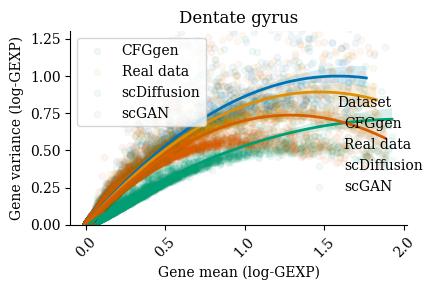

In [33]:
plot_log_mean_vs_log_variance(adata_real_dent, 
                              {"CFGgen": adata_celldreamer_dent, 
                               "scDiffusion": adata_scDiff_dent,
                              "scGAN": adata_scgan_dent}, 
                              "Dentate gyrus", 
                              folder=folder,
                              xlim=None, ylim=(0,1.3), quantile=(0,0.99)
                             )

## C. Elegans

In [17]:
adata_celldreamer_c_elegans = sc.read_h5ad("/home/icb/alessandro.palma/environment/cfgen/project_folder/datasets/generated/tabula_muris/generated_cells_0.h5ad")
adata_scDiff_c_elegans = sc.read_h5ad("/home/icb/alessandro.palma/environment/cfgen/project_folder/baseline_experiments/scDiffusion/generated/tabula_muris/generated_cells_0.h5ad")
# adata_ACTIVA_c_elegans = sc.read_h5ad("/home/icb/alessandro.palma/environment/celldreamer/project_folder/baseline_experiments/ACTIVA/generated/c_elegans/generated_cells_0.h5ad")
adata_scgan_c_elegans = sc.read_h5ad("/home/icb/alessandro.palma/environment/cfgen/project_folder/baseline_experiments/scgan/model_runs/tabula_muris/tabula_muris_generated_0.h5ad")
# adata_scvi_c_elegans = sc.read_h5ad("/home/icb/alessandro.palma/environment/celldreamer/project_folder/baseline_experiments/scvi/c_elegans/generated/c_elegans_0.h5ad")
adata_real_c_elegans = sc.read_h5ad("/home/icb/alessandro.palma/environment/cfgen/project_folder/datasets/processed_full_genome/tabula_muris/tabula_muris_test.h5ad")

Removed 0 obs from Real data
Removed 0 obs from cellFlow
Removed 0 obs from scDiffusion
Removed 0 obs from scGAN


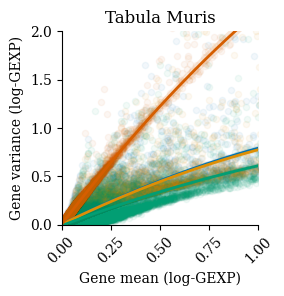

In [18]:
plot_log_mean_vs_log_variance(adata_real_c_elegans, 
                              {"cellFlow": adata_celldreamer_c_elegans,
                               "scDiffusion": adata_scDiff_c_elegans, 
                              "scGAN": adata_scgan_c_elegans}, "Tabula Muris", 
                              folder=folder,
                              xlim=(0,1), ylim=(0,2), quantile=(0,1)
                             )

## PBMC3K

In [19]:
adata_celldreamer_pbmc3k = sc.read_h5ad("/home/icb/alessandro.palma/environment/cfgen/project_folder/datasets/generated/pbmc3k/generated_cells_0.h5ad")
adata_scDiff_pbmc3k = sc.read_h5ad("/home/icb/alessandro.palma/environment/cfgen/project_folder/baseline_experiments/scDiffusion/generated/pbmc3k/generated_cells_0.h5ad")
# adata_ACTIVA_pbmc3k = sc.read_h5ad("/home/icb/alessandro.palma/environment/celldreamer/project_folder/baseline_experiments/ACTIVA/generated/pbmc3k/generated_cells_0.h5ad")
adata_scgan_pbmc3k = sc.read_h5ad("/home/icb/alessandro.palma/environment/cfgen/project_folder/baseline_experiments/scgan/model_runs/pbmc3k/pbmc3k_generated_0.h5ad")
# adata_scvi_pbmc3k = sc.read_h5ad("/home/icb/alessandro.palma/environment/celldreamer/project_folder/baseline_experiments/scvi/pbmc3k/generated/pbmc3k_0.h5ad")
adata_real_pbmc3k = sc.read_h5ad("/home/icb/alessandro.palma/environment/cfgen/project_folder/datasets/processed_full_genome/pbmc3k/pbmc3k_test.h5ad")

Removed 429 obs from Real data
Removed 429 obs from cellFlow
Removed 429 obs from scDiffusion
Removed 429 obs from scGAN


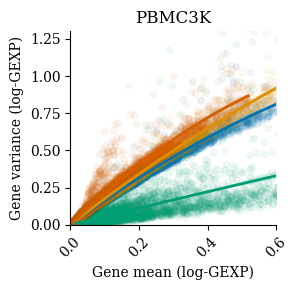

In [20]:
plot_log_mean_vs_log_variance(adata_real_pbmc3k, 
                              {"cellFlow": adata_celldreamer_pbmc3k, "scDiffusion": adata_scDiff_pbmc3k,
                              "scGAN": adata_scgan_pbmc3k}, "PBMC3K", 
                              folder=folder,
                              xlim=(0,0.60), ylim=(0,1.3), quantile=(0,0.95)
                             )

## HLCA CORE

In [21]:
adata_celldreamer_hlca = sc.read_h5ad("/home/icb/alessandro.palma/environment/cfgen/project_folder/datasets/generated/hlca_core/generated_cells_0.h5ad")
adata_scDiff_hlca = sc.read_h5ad("/home/icb/alessandro.palma/environment/cfgen/project_folder/baseline_experiments/scDiffusion/generated/hlca_core/generated_cells_0.h5ad")
# adata_ACTIVA_pbmc3k = sc.read_h5ad("/home/icb/alessandro.palma/environment/celldreamer/project_folder/baseline_experiments/ACTIVA/generated/pbmc3k/generated_cells_0.h5ad")
adata_scgan_hlca = sc.read_h5ad("/home/icb/alessandro.palma/environment/cfgen/project_folder/baseline_experiments/scgan/model_runs/hlca_core/hlca_core_generated_0.h5ad")
# adata_scvi_pbmc3k = sc.read_h5ad("/home/icb/alessandro.palma/environment/celldreamer/project_folder/baseline_experiments/scvi/pbmc3k/generated/pbmc3k_0.h5ad")
adata_real_hlca = sc.read_h5ad("/home/icb/alessandro.palma/environment/cfgen/project_folder/datasets/processed_full_genome/hlca_core/hlca_core_test.h5ad")

In [22]:
adata_celldreamer_hlca.var = adata_real_hlca.var.copy()
adata_scDiff_hlca.var = adata_real_hlca.var.copy()

In [23]:
sc.pp.highly_variable_genes(adata_real_hlca, n_top_genes=15000, subset=True)

In [24]:
adata_scDiff_hlca = adata_scDiff_hlca[:, adata_real_hlca.var.index]
adata_celldreamer_hlca = adata_celldreamer_hlca[:, adata_real_hlca.var.index]
adata_scgan_hlca = adata_scgan_hlca[:, adata_scgan_hlca.var.index]

Removed 753 obs from Real data
Removed 753 obs from cellFlow
Removed 753 obs from scDiffusion
Removed 1398 obs from scGAN


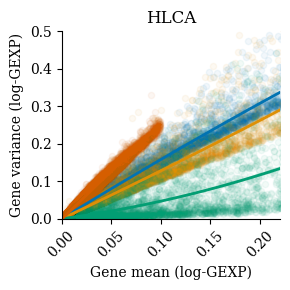

In [25]:
plot_log_mean_vs_log_variance(adata_real_hlca, 
                              {"cellFlow": adata_celldreamer_hlca, "scDiffusion": adata_scDiff_hlca, 
                              "scGAN": adata_scgan_hlca}, "HLCA", 
                              folder=folder,
                              xlim=(0,0.22), ylim=(0,0.50), quantile=(0,0.95)
                             )